# Purpose:
This notebook contains code to build url and fetch geoJSON from a running OTP session on my local computer and compute base and freuqnt service coverage wihtin the MBTAs Service area using their GTFS.

In [179]:
import urllib.request
import csv
import pandas as pd
import time
import contextlib
from shapely.ops import cascaded_union
import geopandas as gpd
import json
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import transform
import numpy as np

 

In [2]:
def buildURL(coord, modes, time_sec):
    """
    coord: tuple of lat,long
    modes: list of modes in string e.g. ['WALK','TRANSIT']
    
    """
    modes = [x.upper() for x in modes]
    # check if modes are alright (do later) and find a way to do more than one mode in the string
    string = "http://localhost:8080/otp/routers/default/isochrone?" + "batch=true" + "&mode=" + modes[0]+ "&cutoffSec=" + str(time_sec)+"&fromPlace="+str(coord[0])+","+str(coord[1]) 
    return string

In [3]:
# setting parameters for the url build
time_s = 600
modes = ['walk']


In [4]:
# load in the CSV with stop locations: all stops for base coverage
with open('/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 2/allMBTAstops.csv','r') as inp:
    allstopsDf = pd.read_csv(inp)

In [5]:
# make a simple list of the coorinates as (lat,lon)
allstops = list(set(zip(allstopsDf.stop_lat, allstopsDf.stop_lon)))

In [22]:
## Make sure OTP is running before: 

# load polygon of walkshed for every stop 
start = time.time()
polygons = dict()
failedcoords = list()
count = 0
for coord in allstops:
    url = buildURL(coord,modes,600)
    try:
        with contextlib.closing(urllib.request.urlopen(url)) as x:
            polygons[coord]= x.read()
    except:
        failedcoords.append([coord])
    count += 1
#     if count == 2: break

print(f'time taken {(time.time() - start)/60}')

time taken 0.9479215343793234


In [111]:
# retain the geometries of these polygons
polygonlist = list()
losthope = list()
for k,v in polygons.items():
    pp = Polygon(json.loads(v)['features'][0]['geometry']['coordinates'][0][0])
    if not pp.is_valid: 
        pp = pp.buffer(0)
        if pp.is_valid: polygonlist.append(pp)
        else: losthope.append(k)
    elif pp.is_valid: polygonlist.append(pp)

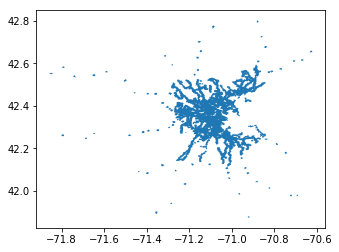

In [114]:
# the join of all the walksheds of the bus stops of the MBTA
boundary = gpd.GeoSeries(cascaded_union(polygonlist))
boundary.plot()
plt.show()

In [131]:
# load the shapefiles as geo-datafames
allstopspoly = gpd.GeoDataFrame(boundary)
area1 = gpd.GeoDataFrame.from_file("/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 2/mbta_service_areas/MBTA Highest Assessment Area/GISDATA_RTASMBTAHIGH_POLYPolygon.shp")
area2 = gpd.GeoDataFrame.from_file("/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 2/mbta_service_areas/MBTA Secondary Assessment Area/GISDATA_RTASMBTASEC_POLYPolygon.shp")
blocks = gpd.GeoDataFrame.from_file("/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 2/block_groups_2010/block_groups_2010.shp")

MBTAserviceAreas = cascaded_union([area1.geometry[0], area2.geometry[0]])



In [156]:
MBTAserviceAreas
blocks.iloc[20]['geometry'].intersection(MBTAserviceAreas).area/blocks.iloc[20]['geometry'].area

1.0

In [155]:

data = []
for index, block in blocks.iterrows():
    if block['geometry'].intersects(MBTAserviceAreas):
        intersection = block['geometry'].intersection(MBTAserviceAreas)
        Area = intersection.area
        proportion = Area/block['geometry'].area
        data.append({'geometry': intersection, 'GEOID10':block['GEOID10'], 'popTotal': block['popTotal']*proportion, 'area_m2':block['ALAND10']})

MBTAblocks = gpd.GeoDataFrame(data,columns=['geometry', 'GEOID10', 'popTotal', 'area_m2'])

MBTAblocks.head() # image from a Jupiter/IPython notebook




,geometry,GEOID10,popTotal,area_m2
0,"POLYGON ((-71.30067 42.30531999999999, -71.300...",250214043022,694.000000,381280
1,"POLYGON ((-71.036997 42.153963, -71.037184 42....",250214203022,1017.000000,787770
2,"POLYGON ((-71.03240699999999 42.177118, -71.03...",250214201003,946.000000,371034
3,(POLYGON ((-70.91562318338407 42.2640038519501...,250214228001,208.915143,1097189
4,POLYGON ((-70.93980999999999 42.24525999999999...,250214228002,670.233771,522205


In [159]:
# compute density in square miles
MBTAblocks['area_sqmi'] = MBTAblocks.area_m2/(2.59e6)
MBTAblocks['density'] = MBTAblocks.popTotal/MBTAblocks.area_sqmi
MBTAblocks.head()

,geometry,GEOID10,popTotal,area_m2,area_sqmi,density
0,"POLYGON ((-71.30067 42.30531999999999, -71.300...",250214043022,694.000000,381280,0.147212,4714.278221
1,"POLYGON ((-71.036997 42.153963, -71.037184 42....",250214203022,1017.000000,787770,0.304158,3343.653604
2,"POLYGON ((-71.03240699999999 42.177118, -71.03...",250214201003,946.000000,371034,0.143256,6603.545767
3,(POLYGON ((-70.91562318338407 42.2640038519501...,250214228001,208.915143,1097189,0.423625,493.160449
4,POLYGON ((-70.93980999999999 42.24525999999999...,250214228002,670.233771,522205,0.201624,3324.183926


In [160]:
MBTAblocks.to_file('blocksMBTAserviceAreas.shp')

/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [176]:
# intersect the boundary polygon of all walksheds with the MBTA servcie area blocks
allstops_walkshed = boundary.unary_union
population_served = 0
for index, block in MBTAblocks.iterrows():
    if block['geometry'].intersects(allstops_walkshed):
        
        intersection = block['geometry'].intersection(allstops_walkshed)
        Area = intersection.area
        proportion = Area/block['geometry'].area
        population_served_i = block['popTotal']*proportion
        population_served += population_served_i
        data.append({'geometry': intersection, 'GEOID10':block['GEOID10'], 'popTotal':block['popTotal'],'popServed': population_served_i, 'block_area_m2':block['area_m2']})
        
print(f'Total population served is {population_served} which makes {round(100*(population_served/sum(MBTAblocks.popTotal)),2)}')


Total population served is 1824098.521303583 which makes 71.71


In [177]:
# intersect the boundary polygon of all walksheds with the MBTA servcie area blocks
allstops_walkshed = boundary.unary_union
population_served = 0
for index, block in MBTAblocks.iterrows():
    if block['geometry'].intersects(allstops_walkshed):
        
        intersection = block['geometry'].intersection(allstops_walkshed)
        Area = intersection.area
        proportion = Area/block['geometry'].area
        population_served_i = block['popTotal']
        population_served += population_served_i
        data.append({'geometry': intersection, 'GEOID10':block['GEOID10'], 'popTotal':block['popTotal'],'popServed': population_served_i, 'block_area_m2':block['area_m2']})
        
print(f'Total population served, taking not pro rated pop is {population_served} which makes {round(100*(population_served/sum(MBTAblocks.popTotal)),2)} percent')


Total population served, taking not pro rated pop is 2314518.7470613606 which makes 90.99 percent


In [210]:
# save the stops walksheds to file for visualization
data1 = list()
for poly in allstops_walkshed.geoms:
    data1.append({'geometry':poly})
allstops_walkshed_df = gpd.GeoDataFrame(data1,columns=['geometry'])
allstops_walkshed_df.to_file('allstops_walksheds.shp')

/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


## For frequent bus serive in dense areas

In [202]:
# load in the CSV with stop locations: Frequent stops for Frequent coverage
with open('/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 2/FrequentMBTAstops.csv','r') as inp:
    frequentstopsDf = pd.read_csv(inp)

# make a simple list of the coorinates as (lat,lon)
frequentstops = list(set(zip(frequentstopsDf.stop_lat, frequentstopsDf.stop_lon)))

## Make sure OTP instance is running with Massachussets OSM loaded before:##

# determine walkshed polygons for every stop coordinates
start = time.time()
polygons = dict()
failedcoords = list()
count = 0
for coord in frequentstops:
    url = buildURL(coord,modes,600)
    try:
        with contextlib.closing(urllib.request.urlopen(url)) as x:
            polygons[coord]= x.read()
    except:
        failedcoords.append([coord])

# retain the geometries of these polygons
polygonlist = list()
losthope = list()
for k,v in polygons.items():
    pp = Polygon(json.loads(v)['features'][0]['geometry']['coordinates'][0][0])
    if not pp.is_valid: 
        pp = pp.buffer(0)
        if pp.is_valid: polygonlist.append(pp)
        else: losthope.append(k)
    elif pp.is_valid: polygonlist.append(pp)
        
print(f'Time taken for walksehd polygons: {round((time.time() - start),2)} seconds with {len(failedcoords)} un-processed stops and {len(losthope)} invalid polygons')



Time taken for walksehd polygons: 14.03 seconds with 0 un-processed stops and 0 invalid polygons


In [205]:
# create a geodataframe with MBTA blocks with high density only
denseMBTAblocks = MBTAblocks[MBTAblocks.density >= 7000]

In [209]:
boundary = gpd.GeoSeries(cascaded_union(polygonlist))

# intersect the boundary polygon of all walksheds with the MBTA servcie area blocks
frequentstops_walkshed = boundary.unary_union
population_served = 0
population_served_npr = 0
for index, block in denseMBTAblocks.iterrows():
    if block['geometry'].intersects(frequentstops_walkshed):
        
        intersection = block['geometry'].intersection(frequentstops_walkshed)
        Area = intersection.area
        proportion = Area/block['geometry'].area
        population_served_i = block['popTotal']*proportion
        population_served += population_served_i
        population_served_npr += block['popTotal']
        
print(f'Total population served is {round(population_served,2)} which makes {round(100*(population_served/sum(denseMBTAblocks.popTotal)),2)} percent pro-rated and {round(100*(population_served_npr/sum(denseMBTAblocks.popTotal)),2)} not pro-rated')




Total population served is 680823.6 which makes 50.7 percent pro-rated and 62.97 not pro-rated
